In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import eig

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow



In [2]:
def cholesky_with_jitter(K, jitter):
    k_diag = tf.linalg.diag_part(K)
    jitter_diag = tf.fill(tf.shape(k_diag), tf.cast(jitter, dtype=K.dtype))
    jittered_K = tf.linalg.set_diag(K, k_diag + jitter_diag)
    return tf.linalg.cholesky(jittered_K)

K = gpflow.kernels.SquaredExponential(variance=1, lengthscales=1)

pi = tf.cast(np.pi, tf.float64)

noise = tf.cast(1, tf.float64)

In [15]:
N = 50
M = 10

In [16]:
Xs = np.linspace(-5, 5, 100).reshape(-1,1)
X = np.random.uniform(-2, 2, N).reshape(-1,1)
Y = tf.math.sin(X)

Z1 = X[0:M]

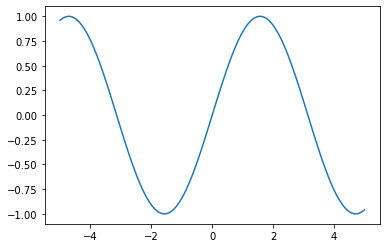

In [17]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,np.sin(Xs))

In [18]:
m1 = tf.Variable(np.zeros(M).reshape(-1,1))
S1 = tf.Variable(np.identity(M))
m2 = tf.Variable(np.zeros(M).reshape(-1,1))
S2 = tf.Variable(np.identity(M))

In [19]:
def elbo(m1,S1,m2,S2):
    
   
    
    f1_sample_list = []

    for i in range (0,N):
        
        f1_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K(X[i].reshape(-1,1),Z1),tf.linalg.inv(K(Z1,Z1))),m1)
        f1_sample_covariance = K(X[i].reshape(-1,1),X[i].reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K(X[i].reshape(-1,1),Z1),tf.linalg.inv(K(Z1,Z1))),K(Z1,X[i].reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K(X[i].reshape(-1,1),Z1),K(Z1,Z1)),S1),tf.linalg.inv(K(Z1,Z1))),K(Z1,X[i].reshape(-1,1)))
        f1_sample = tf.math.reduce_mean(tfp.distributions.Normal(f1_sample_mean,f1_sample_covariance).sample(100))
        f1_sample_list.append(f1_sample)
    
    
    f1_sample_list = np.array(f1_sample_list).reshape(-1,1)
    Z2 = f1_sample_list[0:M]
       
    
    likelihood_GP = tf.cast(0,tf.float64)
        
    for i in range (0,N):
        
        f2_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K(f1_sample_list[i].reshape(-1,1),Z2),tf.linalg.inv(K(Z2,Z2))),m2)
        f2_sample_covariance = K(f1_sample_list[i].reshape(-1,1),f1_sample_list[i].reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K(f1_sample_list[i].reshape(-1,1),Z2),tf.linalg.inv(K(Z2,Z2))),K(Z2,f1_sample_list[i].reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K(f1_sample_list[i].reshape(-1,1),Z2),K(Z2,Z2)),S2),tf.linalg.inv(K(Z2,Z2))),K(Z2,f1_sample_list[i].reshape(-1,1)))
        f2_sample = tf.math.reduce_mean(tfp.distributions.Normal(f2_sample_mean,f2_sample_covariance).sample(100))
        
        likelihood =tf.math.multiply(tf.cast(-1/2,tf.float64),tf.math.log(tf.math.multiply(tf.cast(2,tf.float64),tf.math.multiply(pi,tf.math.square(noise))))) - tf.math.divide(tf.math.square((Y[i]-f2_sample)),tf.math.square(noise))
        likelihood_GP = likelihood_GP + likelihood
        
    KL1 = tf.math.multiply(tf.cast(-1/2,tf.float64),(tf.linalg.trace(tf.linalg.matmul(tf.linalg.inv(K(Z1,Z1)),S1))+tf.linalg.matmul(tf.linalg.matmul(tf.transpose(m1),tf.linalg.inv(K(Z1,Z1))),m1)-M+tf.math.log(tf.linalg.det(cholesky_with_jitter(K(Z1,Z1),1e-3)))-tf.math.log(tf.linalg.det(S1))))
    KL2 = tf.math.multiply(tf.cast(-1/2,tf.float64),(tf.linalg.trace(tf.linalg.matmul(tf.linalg.inv(K(Z2,Z2)),S2))+tf.linalg.matmul(tf.linalg.matmul(tf.transpose(m2),tf.linalg.inv(K(Z2,Z2))),m2)-M+tf.math.log(tf.linalg.det(cholesky_with_jitter(K(Z2,Z2),1e-3)))-tf.math.log(tf.linalg.det(S2))))
    
    KL_GP = KL1+KL2
    
    elbo = likelihood_GP - KL_GP



    return elbo

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
for _ in range(1000):
    with tf.GradientTape() as tape:
        objective = elbo(m1,S1,m2,S2)
        gradients = tape.gradient(objective, [m1,S1,m2,S2])
    optimizer.apply_gradients(zip(gradients, [m1,S1,m2,S2]))

SAMPLE FIRST LAYER

In [21]:
f1_sample_mean = np.matmul(np.matmul(K(Xs,Z1),inv(K(Z1,Z1))),m1)
f1_sample_covariance = K(Xs,Xs)-np.matmul(np.matmul(K(Xs,Z1),inv(K(Z1,Z1))),K(Z1,Xs))+np.matmul(np.matmul(np.matmul(np.matmul(K(Xs,Z1),K(Z1,Z1)),S1),inv(K(Z1,Z1))),K(Z1,Xs))
f1_samples = np.random.multivariate_normal(f1_sample_mean.reshape(100,), f1_sample_covariance, 10)



/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


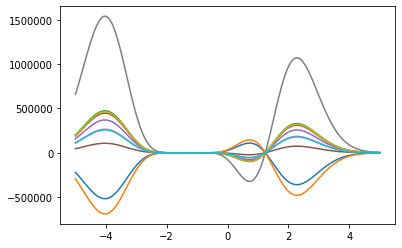

In [22]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f1_samples.T)

In [23]:
f1_sample_list = []

for i in range (0,len(Xs)):
        
    f1_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K(Xs.reshape(-1,1),Z1),tf.linalg.inv(K(Z1,Z1))),m1)
    f1_sample_covariance = K(Xs.reshape(-1,1),Xs.reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K(Xs.reshape(-1,1),Z1),tf.linalg.inv(K(Z1,Z1))),K(Z1,Xs.reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K(Xs.reshape(-1,1),Z1),K(Z1,Z1)),S1),tf.linalg.inv(K(Z1,Z1))),K(Z1,Xs.reshape(-1,1)))
    f1_sample = tf.math.reduce_mean(tfp.distributions.Normal(f1_sample_mean,f1_sample_covariance).sample(100))
    f1_sample_list.append(f1_sample)

In [24]:
f1_sample_list = np.array(f1_sample_list).reshape(-1,1)
Z2 = f1_sample_list[0:M]

In [25]:
f2_sample_mean = np.matmul(np.matmul(K(Xs,Z2),inv(K(Z2,Z2))),m1)
f2_sample_covariance = K(Xs,Xs)-np.matmul(np.matmul(K(Xs,Z2),inv(K(Z2,Z2))),K(Z2,Xs))+np.matmul(np.matmul(np.matmul(np.matmul(K(Xs,Z2),K(Z2,Z2)),S1),inv(K(Z2,Z2))),K(Z2,Xs))
f2_samples = np.random.multivariate_normal(f2_sample_mean.reshape(100,), f2_sample_covariance, 10)




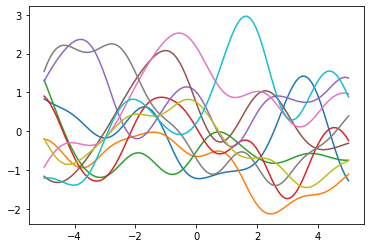

In [26]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f2_samples.T)

In [27]:
f2_sample_mean = np.matmul(np.matmul(K(f1_sample_list,Z2),inv(K(Z2,Z2))),m1)
f2_sample_covariance = K(f1_sample_list,f1_sample_list)-np.matmul(np.matmul(K(f1_sample_list,Z2),inv(K(Z2,Z2))),K(Z2,f1_sample_list))+np.matmul(np.matmul(np.matmul(np.matmul(K(f1_sample_list,Z2),K(Z2,Z2)),S1),inv(K(Z2,Z2))),K(Z2,f1_sample_list))
f2_samples = np.random.multivariate_normal(f2_sample_mean.reshape(100,), f2_sample_covariance, 10)





/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


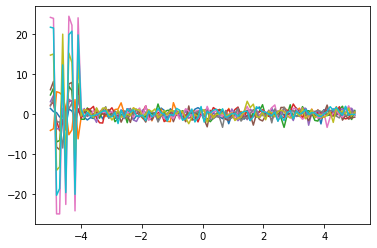

In [28]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f2_samples.T)